In [ ]:
from torch import nn
import torch

# Creating a dataset

In [ ]:
# @title Making a linear dataset

weight = 0.7  # slope
bias = 0.3  # intercept

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1) # X values are stored in a tensor
y = weight * X + bias # Y axis values depend on X

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# @title Splitting into train and test datasets

# Let's use an 80-20 split (w/ no validation set)
# We need to split X and y into 2 parts, each of 80-20 split
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
# @title Let's visualise our data!

import matplotlib.pyplot as plt

def plot_predictions(train_data = X_train,  # We'll also use this function to plot our model's predictions later
              train_labels = y_train,
              test_data = X_test,
              test_labels = y_test,
              predictions = None):
  plt.figure(figsize = (7, 5))

  # Plotting training data (in blue)
  plt.scatter(train_data, train_labels, c = "b", s = 4, label = "Training data")

  # Plotting testing data (in green)
  plt.scatter(test_data, test_labels, c = "g", s = 4, label = "Testing data")

  # Plotting predictions (in red)
  if predictions is not None:
    plt.scatter(test_data, predictions, c = "r", s = 4, label = "Model's predictions")

  # Showing the legend
  plt.legend(prop = {"size":14})

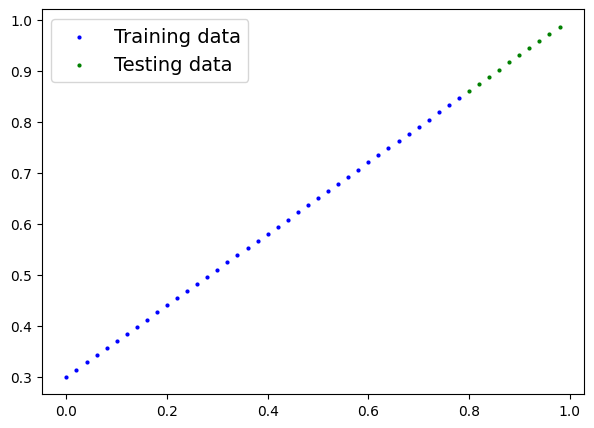

In [ ]:
plot_predictions()

# Building a model

In [ ]:
# @title Finally... let's build our linear regression model!

class LinearRegressionModel(nn.Module): # <- Everything in PyTorch inherits from/is a subclass of nn.Module - it's the building block of NNs
  def __init__(self):
    super().__init__()

    # We're gonna use 2 parameters (since we know our dataset is linear, and hence can describe it w/ 2 parameters)
    # If we had a more complex dataset, like images, nn.Module would help us create better parameters
    self.weight = nn.Parameter(torch.randn(1, # <- We're starting w/ a random weight. The model will learn the correct one through training.
                                           dtype=torch.float,  # <- PyTorch loves float32 by default!
                                           requires_grad=True))  # <- can we update this value w/ gradient descent? True = yes!
    self.bias = nn.Parameter(torch.randn(1,
                                         dtype=torch.float,
                                         requires_grad=True))

  # Now that we've defind our model's parameters, let's write the forward function:
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- 'x' is the input data. This function returns values of type torch.Tensor
    return self.weight * x + self.bias  # <- Same as the linear regression formula!

**Note:** When making predictions w/ a model use `torch.inference_mode()`. This ensures that PyTorch isn't thinking about gradient descent, so the predictions will go a lot faster!

In [ ]:
# @title Instantiating our model and checking it's contents

# Let's set a manual seed for reproducibility
torch.manual_seed(42)

# Then let's instantiate our LR model!
model_0 = LinearRegressionModel()

# Finally we can check its contents (parameters) w/ torch.parameters()
list(model_0.parameters())  # <- If you don't use list(), it gives a generator object

# We can also use torch.state_dict():
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# @title Let's setup our loss function and optimiser first

loss_fn = nn.L1Loss() # <- L1Loss() is the same thing as Mean Absolute Error (MAE)

# Let's use SGD as our optimiser (just cos it's one of the most popular ones)
optimiser = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

We'll usually have to specify two parameters when setting up our optimiser:
1. `params`: This specifies the model parameters that the optimiser will work on.
2. `lr`: The learning rate of the model. Higher lr means more change to the parameters in each iteration, lower lr means less change to the parameters in each iteration.

# Let's make our training and testing loops!
## First, our **training** loop:
We train our model by showing it training data and adjusting its parameters.

There's 5 steps:
0.   **Loop** through our data (for a certain no. of epochs) & set model to **training mode**!
1.   **Forward** pass: Input training data into our `forward()` fn.
2.   Calculate the **loss**: Compare our model's current predictions w/ the ground truth values using our `loss_fn`
3.   Optimiser **zero grad**: This ensures that our optimiser's gradients are reset (to 0) every iteration, since it accumulates by default (we don't want that)
4.   Perfom **backpropagation** on the loss: Go backward and calculate the gradients of each model parameter that needs to be updated (i.e. has `requires_grad=True`) w.r.t the loss
5.    **Update** the optimiser: Update each parameter that needs to be updated according to their gradient w.r.t. the loss to improve them

## Then, our **testing** loop...
Here, we're *evaluating* our model on the *testing* data.

There's only 2 steps here:
0.  **Loop** through, set the model to **evaluation mode** using `.eval()`, and use the `torch.inference_mode()` context manager. These 2 functions tell PyTorch to stop keeping track of gradients and other things that are not required for evaluation, so that our evaluations go faster!
1.  **Forward pass** to get the predictions on our testing data
2.  Calculate the **loss** on our testing data + any other evaluation metric you wanna use

In [ ]:
# @title Writing our training and testing loops!

torch.manual_seed(42)

epochs = 200  # <- No. of epochs is an important hyperparameter

# Let's make empty lists so we can store info later
epoch_count = []
train_loss_values = []
test_loss_values = []

# 0. Loop for no. of epochs
for epoch in range(epochs):
  ## Training part
  # 0. Set model to training mode
  model_0.train()

  # 1. Forward pass (pass input data to model and get output (predictions))
  y_pred = model_0(X_train)

  # 2. Calculate the loss w/: loss_fn(input, target)
  train_loss = loss_fn(y_pred, y_train)

  # 3. Reset optimiser gradients (zero_grad())
  optimiser.zero_grad()

  # 4. Backpropagate to calculate gradients of each parameter (that needs to be changed)
  train_loss.backward()

  # 5. Update the optimiser, changing it according to calculated gradient of parameters (take a step)
  optimiser.step()


  ### Testing part
  # 0. Set model to evaluation mode
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass (w/ testing data)
    test_pred = model_0(y_test)

    # 2. Calculate loss + other evaluation metrics
    test_loss = loss_fn(test_pred, y_test)

    if epoch % 20 == 0: # <- Print out the status of the model in each epoch
      epoch_count.append(epoch) # <- We use these lists to plot our model's progress
      train_loss_values.append(train_loss.detach().numpy()) # <- .detach() returns a tensor that isn't connected to the NN (i.e. doesn't store gradients)
      test_loss_values.append(test_loss.detach().numpy()) # <- .numpy() turns our detached tensor to a np array, which we can plot w/ matplotlib
      print("Epoch: {} | Train loss: {} | Test loss: {}".format(epoch, train_loss, test_loss))

      # Let's also print out the model's parameters. In this example, we know what they're supposed to be so we can directly compare!
      print(model_0.state_dict())
      print()

Epoch: 0 | Train loss: 0.31288138031959534 | Test loss: 0.4698256850242615
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])

Epoch: 20 | Train loss: 0.08908725529909134 | Test loss: 0.20348870754241943
OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])

Epoch: 40 | Train loss: 0.04543796554207802 | Test loss: 0.09794081002473831
OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])

Epoch: 60 | Train loss: 0.03818932920694351 | Test loss: 0.07198350876569748
OrderedDict([('weight', tensor([0.5116])), ('bias', tensor([0.3788]))])

Epoch: 80 | Train loss: 0.03132382780313492 | Test loss: 0.05430586263537407
OrderedDict([('weight', tensor([0.5459])), ('bias', tensor([0.3648]))])

Epoch: 100 | Train loss: 0.024458957836031914 | Test loss: 0.0373220220208168
OrderedDict([('weight', tensor([0.5800])), ('bias', tensor([0.3503]))])

Epoch: 120 | Train loss: 0.01758546568453312 | Test loss: 0.021132390946149826
OrderedDict([('weight'

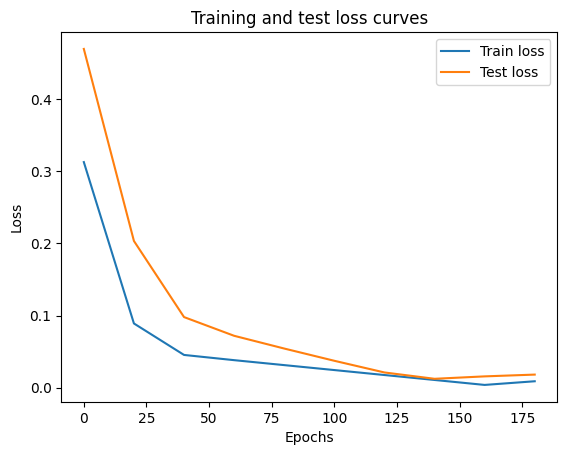

In [ ]:
# @title Visualising the training and testing loss curves

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

Over 300 epochs, our model learns the weight and bias parameters to be 0.6951 and 0.2993 respectively. The correct weight and bias for our linear dataset is 0.7 and 0.3. It got pretty close!

# Making predictions with our trained model

In [ ]:
# @title Making predictions on testing data with our working model

# 1. Set the model to evaluation mode
model_0.eval()

# 2. Use the .inference_mode() context manager
with torch.inference_mode():
  y_preds = model_0(X_test)

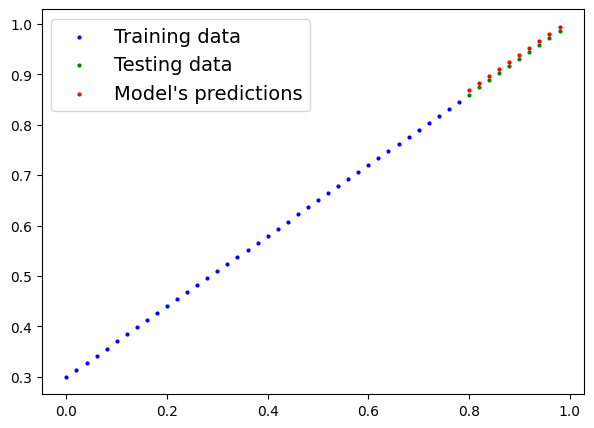

In [ ]:
# @title And now, let's visualise our predictions

plot_predictions(predictions=y_preds)

# Saving and loading our model
There's 3 main functions we need when saving and loading a model:
1.  `torch.save()`: This will save the model into Google Colab.
2.  `torch.load()`: This will load our model from Google Colab.
3.  `torch.nn.Module.load_state_dict()`: This will load a model's parameter dictionary using a saved `state_dict()` object.

PyTorch models have the extension `.pth` or `.pt`. Once saved to Colab, the model will still be lost once the runtime disconnects so we need to save the model to a local directory, or preferably, to Google Drive.

We can also save the model in 2 ways:
1.  Saving the model's parameters using `state_dict()` (recommended).
2.  Saving the entire model using pickling.

"The disadvantage of this approach is that the serialized data is bound to the *specific classes* and the *exact directory structure* used when the model is saved. The reason for this is because pickle does not save the model class itself. Rather, it saves *a path to the file containing the class*, which is used during load time. Because of this, **your code can break** in various ways when used in other projects or after refactors."

In [ ]:
# @title Let's save our linear regression model

from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,  # <- The parents=True argument tells Python to create any necessary parent directories
                 exist_ok=True) # <- exist_ok=True allows the operation to proceed without raising an exception if the directory already exists.

# 2. Create model save path
MODEL_NAME = "01_LinearRegressionModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print("Saving model to {}".format(MODEL_SAVE_PATH))
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to models/01_LinearRegressionModel.pth


In [ ]:
# Check the saved file path
!ls -l models/01_LinearRegressionModel.pth

-rw-r--r-- 1 root root 1662 Feb  8 06:58 models/01_LinearRegressionModel.pth


## Let's save our model to Google Drive

In [ ]:
# @title First need to mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Now save to drive!
# Again, the same 3 steps for saving are used.

# 1. I already made the directory manually in my drive.
# I'm gonna use the directory: "My Drive/Colab Notebooks/Models/PyTorch Tutorial".

# 2. Create model save path
MODEL_NAME = "01_LinearRegressionModel.pth"
MODEL_SAVE_PATH_GDRIVE = f"/content/drive/My Drive/Colab Notebooks/Models/PyTorch Tutorial/{MODEL_NAME}"

# 3. Save the model state_dict()
print("Saving model to {}".format(MODEL_SAVE_PATH_GDRIVE))
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH_GDRIVE)

Saving model to /content/drive/My Drive/Colab Notebooks/Models/PyTorch Tutorial/01_LinearRegressionModel.pth


## Let's load our model back
When we load our model, we're only loading the model's saved `state_dict()`. To use this, we need to instantiate a new instance of our model class, then set this new instance's `state_dict()` to be equal to the saved `state_dict()`.

In [ ]:
# @title First, let's load it back from Colab

# Create a new instance of our model
loaded_model_0 = LinearRegressionModel()

# Then load in the saved state_dict()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
# @title We can do the same from drive

loaded_gdrive_model_0 = LinearRegressionModel()
loaded_gdrive_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH_GDRIVE))

<All keys matched successfully>

In [ ]:
# @title We can use this loaded model to make the same predictions

loaded_gdrive_model_0.eval()

with torch.inference_mode():
  loaded_y_preds = loaded_gdrive_model_0(X_test)

In [ ]:
# @title Compare the saved model to the loaded model (they'll be the same)

y_preds == loaded_y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it all together

Let's do this all again, this time using torch.nn to make our parameters for us as well as device agnostic code! Here are the steps:

1. Get data (generate and split data)
2. Build model (using nn.Linear)
3. Train model
4. Test model
5. Save (and load back) model

## 1. Get data
Let's just use our old dataset (the steps to make a new dataset would've been exactly the same).

In [ ]:
X_train, X_test, y_train, y_test

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800],
         [0.4000],
         [0.4200],
         [0.4400],
         [0.4600],
         [0.4800],
         [0.5000],
         [0.5200],
         [0.5400],
         [0.5600],
         [0.5800],
         [0.6000],
         [0.6200],
         [0.6400],
         [0.6600],
         [0.6800],
         [0.7000],
         [0.7200],
         [0.7400],
         [0.7600],
         [0.7800]]),
 tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.3000],
         [0.3140],
        

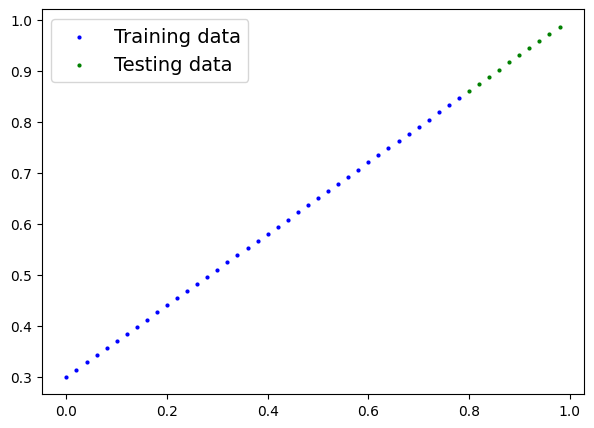

In [ ]:
# @title Plot the data

plot_predictions()

## 2. Build model
We're gonna use `nn.Linear` to make our linear regression model this time. `torch.nn` has a bunch of layers that we can use to make models with, like convolutional, dropout, linear/dense/FC, etc. layers.

`nn.Linear` learns a weight and a bias to best match predictions to input variables.

The two parameters given are `in_features` (size of each input sample) and `out_features` (size of each output sample).

In [ ]:
# @title Building the linear regression model

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,  # <- size of each input sample is just 1 value
                                  out_features=1) # <- size of each output sample is also 1 value
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Additionally, set manual seed and instantiate the model
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# @title Writing device agnostic code
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model_1.to(device)  # <- will send model to GPU if available, else will stay on the CPU by default
next(model_1.parameters()).device

device(type='cpu')

## 3 & 4. Training and testing the model

In [ ]:
# @title Selecting loss function and optimiser

loss_fn = nn.L1Loss()
optimiser = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.002) # <- I'm decreasing the lr (and I'll increase the no. of epochs for hopefully better results)

In [ ]:
# @title Training loop

torch.manual_seed(42)

epoch_count = []
train_loss_values = []
test_loss_values = []

# Send all tensors/data to device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  ## Testing
  # 0. Set model to training mode
  model_1.train()

  # 1. Do the forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  train_loss = loss_fn(y_pred, y_train)

  # 3. Optimiser zero grad
  optimiser.zero_grad()

  # 4. Loss backward
  train_loss.backward()

  # 5. Update optimiser
  optimiser.step()

  ## Testing
  # 1. Set model to testing mode
  model_1.eval()

  # 2. Forward pass (w/ inference mode)
  with torch.inference_mode():
    test_pred = model_1(X_test)

    # 3. Calculate loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    epoch_count.append(epoch) # <- We use these lists to plot our model's progress
    train_loss_values.append(train_loss.detach().numpy()) # <- .detach() returns a tensor that isn't connected to the NN (i.e. doesn't store gradients)
    test_loss_values.append(test_loss.detach().numpy()) # <- .numpy() turns our detached tensor to a np array, which we can plot w/ matplotlib
    print("Epoch: {}\tLoss: {}\tTest loss: {}".format(epoch, train_loss, test_loss))
    print(model_1.state_dict())
    print()

Epoch: 0	Loss: 0.5551779866218567	Test loss: 0.5847529768943787
OrderedDict([('linear_layer.weight', tensor([[0.7638]])), ('linear_layer.bias', tensor([0.8280]))])

Epoch: 100	Loss: 0.3247610628604889	Test loss: 0.31533679366111755
OrderedDict([('linear_layer.weight', tensor([[0.6858]])), ('linear_layer.bias', tensor([0.6280]))])

Epoch: 200	Loss: 0.09434310346841812	Test loss: 0.04591952636837959
OrderedDict([('linear_layer.weight', tensor([[0.6078]])), ('linear_layer.bias', tensor([0.4280]))])

Epoch: 300	Loss: 0.019899100065231323	Test loss: 0.046085845679044724
OrderedDict([('linear_layer.weight', tensor([[0.6015]])), ('linear_layer.bias', tensor([0.3416]))])

Epoch: 400	Loss: 0.01302230916917324	Test loss: 0.03036457858979702
OrderedDict([('linear_layer.weight', tensor([[0.6355]])), ('linear_layer.bias', tensor([0.3270]))])

Epoch: 500	Loss: 0.006154827773571014	Test loss: 0.014231031760573387
OrderedDict([('linear_layer.weight', tensor([[0.6697]])), ('linear_layer.bias', tensor([

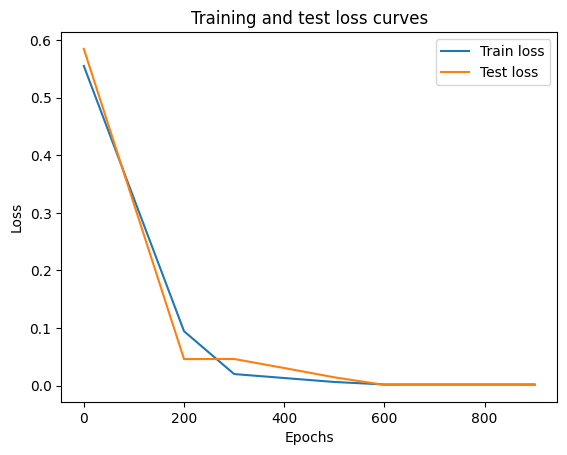

In [ ]:
# @title Visualise loss curves

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

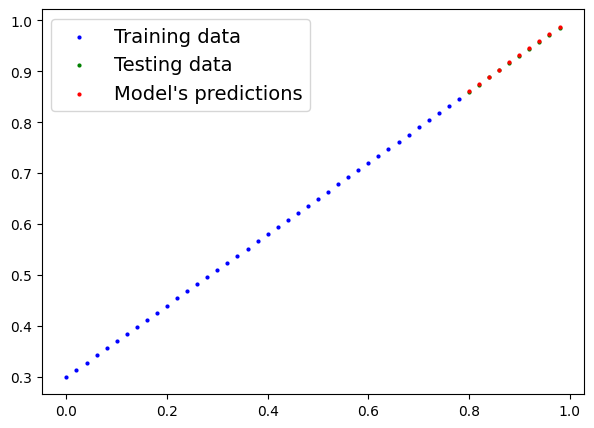

In [ ]:
# @title Making predictions and visualising

model_1.eval()

with torch.inference_mode():
  y_pred = model_1(X_test)

plot_predictions(predictions=y_pred.cpu())

## 5. Saving the model
Let's revise how to save and load a model to Drive.

In [ ]:
# @title Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Save model

MODEL_NAME = "01_LinearRegressionModelV2.pth"
MODEL_SAVE_PATH = f"/content/drive/My Drive/Colab Notebooks/Models/PyTorch Tutorial/{MODEL_NAME}"

print("Saving model to {}".format(MODEL_SAVE_PATH))
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to /content/drive/My Drive/Colab Notebooks/Models/PyTorch Tutorial/01_LinearRegressionModelV2.pth


In [ ]:
# @title Load model

loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
# @title Compare original to loaded model

loaded_model_1.eval()
with torch.inference_mode():
  loaded_pred = model_1(X_test)

y_pred == loaded_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])